In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import spaces
import pyrealsense2 as rs


# using the wrapper

In [5]:
import pyrs12

In [3]:
with pyrs12.Camera() as cam:
    for i in range(10):
        cam.wait_for_frames()
    cam.wait_for_frames()
    c = cam.color
    d = cam.depth

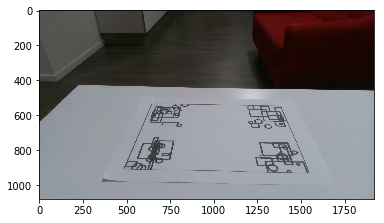

In [4]:
plt.imshow(c)

In [10]:
cam = pyrs12.Camera()
cam.start()

In [11]:
cam.wait_for_frames()

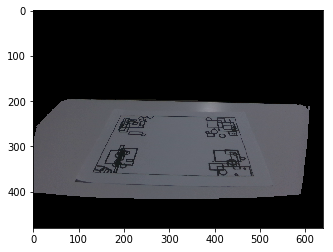

In [12]:
plt.imshow(cam.cad)

(480, 640, 3)

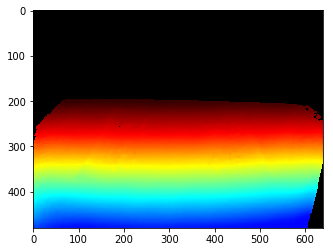

In [8]:
plt.imshow(cam.dac)
cam.dac.shape

In [21]:
cam.stop()

# computing the scene

In [22]:
cam.start()

In [23]:
scene = spaces.Scene(cam, './rgb-marker.png')

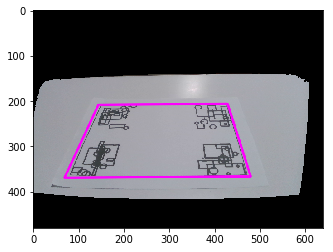

In [24]:
plt.imshow(scene.draw_surface(cam.cad))

In [25]:
scene.system.pattern.homography

array([[ 3.88791811e-01, -1.90147774e-01,  1.46822132e+02],
       [-3.87485488e-03,  1.04986344e-01,  2.09803207e+02],
       [-5.89925279e-06, -6.02654796e-04,  1.00000000e+00]])

In [26]:
scene.system.pcl_center

array([-0.02724761,  0.02057775,  0.35821173], dtype=float32)

In [27]:
depth = cam.depth

In [28]:
cam.stop()

In [29]:
import yaml

In [30]:
with open('sr300_610205001689.param', 'r') as fh:
    d = yaml.load(fh)
intr_ = d['610205001689']

In [31]:
intr = rs.intrinsics()

In [32]:
intr.coeffs = intr_['coeffs']
intr.width  = intr_['width']
intr.height = intr_['height']
intr.ppx    = intr_['ppx']
intr.ppy    = intr_['ppy']
intr.fx     = intr_['fx']
intr.fy     = intr_['fy']
# intr.model  = intr_['model']
intr.coeffs = intr_['coeffs']

ds = intr_['depth_scale']

In [33]:
%load_ext cython

In [34]:
%%cython --annotate
import numpy as np
cimport numpy as np
import pyrealsense2 as rs

DTYPE = np.float32
ctypedef np.float32_t DTYPE_t

def deproject_depth_cy(short[:,:]depth_image, intr, double depth_scale):
    
    cdef int height = intr.height
    cdef int width  = intr.width
    cdef int dx, dy
    cdef float depth_value
    
    cdef np.ndarray[DTYPE_t, ndim=3] pointcloud = np.zeros((height, width, 3), dtype=np.float32)
    
    cdef res = []
    cdef np.ndarray[DTYPE_t, ndim=1] point = np.zeros(3, dtype=np.float32)
    
    cdef float x,y, r2, f, ux, uy
    cdef float ppx, ppy, fx, fy, c0, c1, c2, c3, c4
    
    ppx = intr.ppx
    ppy = intr.ppy
    fx  = intr.fx
    fy  = intr.fy
    c0  = intr.coeffs[0]
    c1  = intr.coeffs[1]
    c2  = intr.coeffs[2]
    c3  = intr.coeffs[3]
    c4  = intr.coeffs[4]
    
    for dy in range(height):
        for dx in range(width):
            depth_value = depth_image[dy, dx] * depth_scale
            if depth_value == 0: continue

            x = (dx - ppx) / fx;
            y = (dy - ppy) / fy;
            r2  = x*x + y*y;
            f = 1 + c0*r2 + c1*r2*r2 + c4*r2*r2*r2;
            ux = x*f + 2*c2*x*y + c3*(r2 + 2*x*x);
            uy = y*f + 2*c3*x*y + c2*(r2 + 2*y*y);
            
            x = ux;
            y = uy;
#             point[0] = depth_value * x;
#             point[1] = depth_value * y;
#             point[2] = depth_value;
#             for i in range(3):
#                 pointcloud[dy, dx, i] = point[i]
            
            pointcloud[dy, dx, 0] = depth_value * x;
            pointcloud[dy, dx, 1] = depth_value * y;
            pointcloud[dy, dx, 2] = depth_value;

    
    return pointcloud

In [35]:
pc_cy = np.asanyarray(deproject_depth_cy(depth.astype(np.int16), intr, ds))

In [36]:
point = np.dot(scene.system.pattern.homography, (pc_cy - scene.system.pcl_center).reshape((-1,3)).T).T

# working with pointclouds

In [6]:
import vtkplot

In [7]:
cam = pyrs12.Camera()
cam.start()

In [8]:
for i in range(10):
    cam.wait_for_frames()
scene = spaces.Scene(cam, './rgb-marker.png')

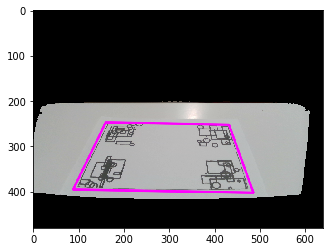

In [9]:
plt.imshow(scene.draw_surface(cam.cad))

In [ ]:
vtkplot.plot_objects(cam.pointcloud, scene.system.denormalise(scene.volume), axis=True)

In [ ]:
import pptk
pptk.viewer(scene.volume)

In [78]:
cam.stop()